In [2]:
import numpy as np
import mne
import os
import sys
from mne.datasets import eegbci
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
mne.set_log_level('WARNING')

## EEG Motor Movement/Imagery Dataset

1. https://www.physionet.org/content/eegmmidb/1.0.0/
2. Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004
3. https://mne.tools/stable/auto_examples/index.html

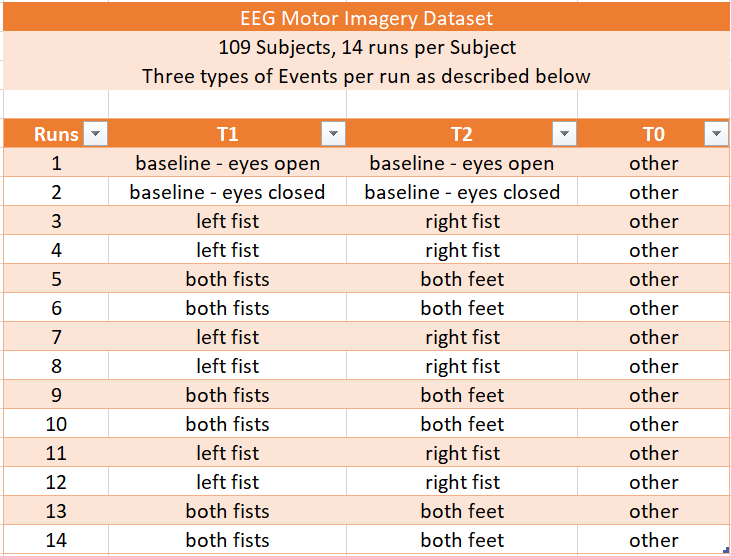

### Defining a motorImagery class for Data Loading and Pre-processing

In [3]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=1, channel_selection=False):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        if channel_selection:
            self.epochs = self.epochs.pick_channels(self.epochs.ch_names[:21])
        return self.epochs, self.labels
    
    def get_X_y(self, channel_selection=False):
        self.return_epochs(channel_selection=channel_selection)
        return self.epochs.get_data(), self.labels

### Experiment Design - #1

The task is to distinguish between hand motor imagery signals and feet movement motor imagery signals. We use EEG data from just one subject for this experiment. For the moment, we are not using any Artifact Handling techniques. We use Common Spatial Pattern Algorithm to apply spatial filter to EEG signals and compare results to just using raw signal values. Furthermore, we are using Logistic Regression model to classify the CSP filtered signals. The number of components resulting after application of spatial filters is a hyperparameter and will be determined using cross validation. We will see the variation in this hyperparameter as we increase the number of subjects.

Subject = 1

Channel Selection = ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5',                      'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6']

Filtering = True (7-30 Hz Bandpass)

Artifact Handling = False

Downsampling = None

Baseline = False

CSP = True

Classification Method = Logistic Regression, SVM & LDA

#### Loading data using the motorImagery class

In [4]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1]
runs = [6,10,14]
eeg = motorImagery(dataset_path, subjects, runs)

#eeg.apply_filter(freq=(7,30))
X, y = eeg.get_X_y()
X.shape

Loading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edf

(45, 64, 161)

In [5]:
epochs,_ = eeg.return_epochs()
channels = epochs.ch_names
print("Selected channels for further processing:\n", channels)

Selected channels for further processing:
 ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']


In [8]:
channels[57]

'POz'

In [30]:
X[0,25,1]

-0.000101

In [67]:
def convert_to_2d_mesh(X, t):
    mesh = np.zeros((10, 11))
    mesh[0] = [0,0,0,0, X[21,t], X[22,t], X[23,t], 0,0,0,0]
    mesh[1] = [0,0,0, X[24,t], X[25,t], X[26,t], X[27,t], X[28,t], 0,0,0]
    mesh[2] = [0, X[29,t], X[30,t], X[31,t], X[32,t], X[33,t], X[34,t], X[35,t], X[36,t], X[37,t], 0]
    mesh[3] = [0, X[38,t], X[0,t], X[1,t], X[2,t], X[3,t], X[4,t], X[5,t], X[6,t], X[39,t], 0]
    mesh[4] = [X[42,t], X[40,t], X[7,t], X[8,t], X[9,t], X[10,t], X[11,t], X[12,t], X[13,t], X[41,t], X[43,t]]
    mesh[5] = [0, X[44,t], X[14,t], X[15,t], X[16,t], X[17,t], X[18,t], X[19,t], X[20,t], X[45,t], 0]
    mesh[6] = [0, X[46,t], X[47,t], X[48,t], X[49,t], X[50,t], X[51,t], X[52,t], X[53,t], X[54,t], 0]
    mesh[7] = [0,0,0, X[55,t], X[56,t], X[57,t], X[58,t], X[59,t], 0,0,0]
    mesh[8] = [0,0,0,0, X[60,t], X[61,t], X[62,t], 0,0,0,0]
    mesh[9] = [0,0,0,0,0, X[63,t], 0,0,0,0,0]
    
    mesh = (mesh-mesh.mean())/mesh.std()
    return mesh

In [74]:
X2d = convert_to_2d_mesh(X[1], 100)     # input arguments = X[sample_no], timestamp
X2d

array([[ 1.0421978 ,  1.0421978 ,  1.0421978 ,  1.0421978 , -1.49427196,
        -1.02702753, -0.82677991,  1.0421978 ,  1.0421978 ,  1.0421978 ,
         1.0421978 ],
       [ 1.0421978 ,  1.0421978 ,  1.0421978 , -1.19390054, -1.06040213,
        -0.5597831 , -0.69328151, -0.72665611,  1.0421978 ,  1.0421978 ,
         1.0421978 ],
       [ 1.0421978 , -0.35953549, -1.76126877, -0.39291009, -0.42628469,
        -0.49303389, -0.12591327, -0.05916407,  0.50820417, -1.49427196,
         1.0421978 ],
       [ 1.0421978 , -0.89352912, -0.72665611, -1.22727514, -1.02702753,
        -1.49427196, -1.12715133, -0.39291009, -0.19266248,  0.64170258,
         1.0421978 ],
       [-0.69328151, -0.72665611, -0.45965929, -1.02702753, -1.62777036,
        -2.2285132 , -1.06040213, -0.5931577 ,  0.10770894,  1.10894701,
        -0.35953549],
       [ 1.0421978 , -1.16052594, -1.06040213, -1.09377673, -1.59439576,
        -1.96151639, -1.36077355, -1.09377673, -0.6599069 , -0.05916407,
         1.042

In [84]:
def create_window(X, S):
    timestamps = X.shape[1]
    mesh2d_allTime = np.zeros((timestamps-(timestamps%S),10,11))
    n_windows = int(timestamps/S)
    windows = np.zeros((n_windows, S, 10, 11))    
    for t in range(timestamps-(timestamps%S)):
        mesh2d_allTime[t,:] = convert_to_2d_mesh(X, t)
        #print(mesh2d_allTime[t,:])
        
    #print(mesh2d_allTime.shape)
    for i in range(0,160,S):
        j=0
        win = mesh2d_allTime[i:i+S]    # Windowing operation
        print(win)
        windows[j,:] = win             # add to array
        #print(windows[j,:])
        j+=1
    
    print(windows.shape)
    print(windows)
    return windows

S=40 # Window size in time domain

X_window = create_window(X[0], S)
print("(No. of Windows, Window_Size, height, width)")
#X_window

[[[ 0.83294723  0.83294723  0.83294723 ...  0.83294723  0.83294723
    0.83294723]
  [ 0.83294723  0.83294723  0.83294723 ...  0.83294723  0.83294723
    0.83294723]
  [ 0.83294723 -0.64735687 -0.82410959 ... -1.68577914 -0.93458005
    0.83294723]
  ...
  [ 0.83294723  0.83294723  0.83294723 ...  0.83294723  0.83294723
    0.83294723]
  [ 0.83294723  0.83294723  0.83294723 ...  0.83294723  0.83294723
    0.83294723]
  [ 0.83294723  0.83294723  0.83294723 ...  0.83294723  0.83294723
    0.83294723]]

 [[ 0.83476978  0.83476978  0.83476978 ...  0.83476978  0.83476978
    0.83476978]
  [ 0.83476978  0.83476978  0.83476978 ...  0.83476978  0.83476978
    0.83476978]
  [ 0.83476978 -0.54234052 -0.64627338 ... -1.91945083 -0.98405515
    0.83476978]
  ...
  [ 0.83476978  0.83476978  0.83476978 ...  0.83476978  0.83476978
    0.83476978]
  [ 0.83476978  0.83476978  0.83476978 ...  0.83476978  0.83476978
    0.83476978]
  [ 0.83476978  0.83476978  0.83476978 ...  0.83476978  0.83476978
    0.

In [70]:
def convert_to_2d(X,S):
    m = X.shape[0]
    n = X.shape[1]
    timestamps = X.shape[2]
    n_windows = int(timestamps/S)
    X_2d = np.zeros((m, n_windows, S, 10, 11))
    for i in range(X.shape[0]):
        win = create_window(X[i], S)
        #print(win.shape)
        X_2d[i,:] = win
    return X_2d
    
S=40               # Window size in time domain
print('(Batch_size, No. of Windows, Window_Size, height, width)')
train_data = convert_to_2d(X,S)
train_data.shape

(Batch_size, No. of Windows, Window_Size, height, width)


(45, 4, 40, 10, 11)

In [71]:
train_data

array([[[[[-8.05208973e-01, -8.05208973e-01, -8.05208973e-01, ...,
           -8.05208973e-01, -8.05208973e-01, -8.05208973e-01],
          [-8.05208973e-01, -8.05208973e-01, -8.05208973e-01, ...,
           -8.05208973e-01, -8.05208973e-01, -8.05208973e-01],
          [-8.05208973e-01, -8.80334492e-01,  8.09989687e-01, ...,
            2.08985535e-01,  7.72426928e-01, -8.05208973e-01],
          ...,
          [-8.05208973e-01, -8.05208973e-01, -8.05208973e-01, ...,
           -8.05208973e-01, -8.05208973e-01, -8.05208973e-01],
          [-8.05208973e-01, -8.05208973e-01, -8.05208973e-01, ...,
           -8.05208973e-01, -8.05208973e-01, -8.05208973e-01],
          [-8.05208973e-01, -8.05208973e-01, -8.05208973e-01, ...,
           -8.05208973e-01, -8.05208973e-01, -8.05208973e-01]],

         [[-7.97564379e-01, -7.97564379e-01, -7.97564379e-01, ...,
           -7.97564379e-01, -7.97564379e-01, -7.97564379e-01],
          [-7.97564379e-01, -7.97564379e-01, -7.97564379e-01, ...,
      

In [66]:
train_data.reshape(180,40,10,11).shape

(45, 160, 10, 11)

#### Binary Classification of CSP filtered values - A Comparison between Logistic Regression, SVM and LDA

##### Cross-Validation

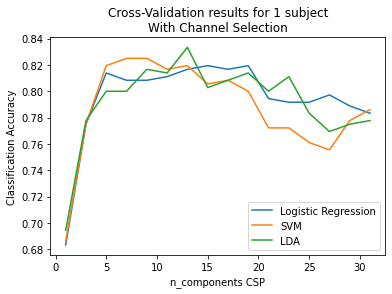

In [67]:
def train_model(csp_components, X, y):
    csp = mne.decoding.CSP(n_components=csp_components, norm_trace=True)
    
    log_regressor = LogisticRegression(max_iter=10000)
    svc = SVC(C=1,kernel='linear')
    lda = LinearDiscriminantAnalysis()
    
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    scores_lr = []
    scores_svm = []
    scores_lda = []

    for train_idx, test_idx in cv.split(y):
        y_train, y_test = y[train_idx], y[test_idx]

        X_train = csp.fit_transform(X[train_idx], y_train)
        X_test = csp.transform(X[test_idx])

        # fit classifiers
        log_regressor.fit(X_train, y_train)
        svc.fit(X_train, y_train)
        lda.fit(X_train, y_train)
        
        scores_lr.append(log_regressor.score(X_test, y_test))
        scores_svm.append(svc.score(X_test, y_test))
        scores_lda.append(lda.score(X_test, y_test))
        
    return np.mean(scores_lr), np.mean(scores_svm), np.mean(scores_lda) #Returns mean accuracy for this hyperparameter value


plt.plot(n_components, accuracy_lr, label="Logistic Regression")
plt.plot(n_components, accuracy_svm, label="SVM")
plt.plot(n_components, accuracy_lda, label="LDA")
plt.xlabel("n_components CSP")
plt.ylabel("Classification Accuracy")
plt.title("Cross-Validation results for 1 subject\nWith Channel Selection")
plt.legend()
plt.savefig("./results/Comparison of ML Models for EEG Classification - with channel selection.png", 
             bbox_inches='tight', transparent=True, dpi=100)

### Comparing Classification accuracy for subjects 1-10 using Classification Models for Linearly-separable data

In [53]:
def train(X, y):
    n_components = np.arange(1,25,2)
    accuracy_lr = []
    accuracy_svm = []
    accuracy_lda = []

    for number in n_components:
        lr_score, svm_score, lda_score = train_model(int(number), X, y)
        accuracy_lr.append( lr_score )
        accuracy_svm.append( svm_score )
        accuracy_lda.append( lda_score )
    return np.max(accuracy_lr), np.max(accuracy_svm), np.max(accuracy_lda)

In [54]:
subjects = [1,2,3,4,5,6,7,8,9,10]
runs = [6,10,14]
accuracy=[]

for subject in subjects:
    eeg = motorImagery(dataset_path, [subject], runs)
    eeg.apply_filter(freq=(7,30))
    X, y = eeg.get_X_y(channel_selection=True)
    accuracy_lr, accuracy_svm, accuracy_lda = train(X, y)
    accuracy.append([accuracy_lr, accuracy_svm, accuracy_lda])
    
print(accuracy)

Loading files at index: [5, 9, 13]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S001/S001R14.edfLoading files at index: [19, 23, 27]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R14.edfLoading files at index: [33, 37, 41]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S003/S003R14.edfLoading files at index: [47, 51, 55]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S004/S004R14.edfLoading files at index: [61, 65, 69]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S005/S005R14.edfLoading files at index: [75, 79, 83]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S006/S006R14.edfLoading files at index: [89, 93, 97]
Loading file #3/3: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S007/S007R14.edfLoading files at index: [103, 107, 111]
Loading file #3/3: H:\BCI Proje

Subject 0, accuracy: [0.98888889 0.96666667 0.97777778]
Subject 1, accuracy: [0.82222222 0.83333333 0.82222222]
Subject 2, accuracy: [0.5        0.48888889 0.54444444]
Subject 3, accuracy: [0.85555556 0.84444444 0.76666667]
Subject 4, accuracy: [0.6        0.61111111 0.6       ]
Subject 5, accuracy: [0.62222222 0.58888889 0.63333333]
Subject 6, accuracy: [0.9 0.9 0.9]
Subject 7, accuracy: [0.95555556 0.93333333 0.94444444]
Subject 8, accuracy: [0.57777778 0.61111111 0.64444444]
Subject 9, accuracy: [0.83333333 0.84444444 0.83333333]


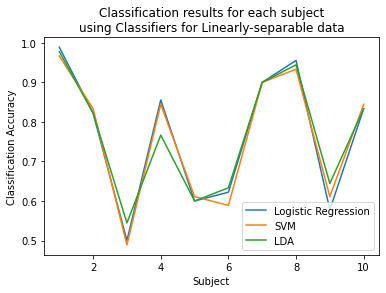

In [69]:
for i,a in enumerate(accuracy):
    print(f"Subject {i}, accuracy: {a}")
    
a=accuracy
accuracy=np.array(accuracy)
lr_accuracy = accuracy[:,0]
svm_accuracy = accuracy[:,1]
lda_accuracy = accuracy[:,2]
subjects_no = np.arange(1,11,1)

plt.plot(subjects_no, lr_accuracy, label="Logistic Regression")
plt.plot(subjects_no, svm_accuracy, label="SVM")
plt.plot(subjects_no, lda_accuracy, label="LDA")

plt.xlabel("Subject")
plt.ylabel("Classification Accuracy")
plt.title("Classification results for each subject\nusing Classifiers for Linearly-separable data")
plt.legend()
plt.savefig("./results/Comparison of EEG Source Subjects - with channel selection.png", 
             bbox_inches='tight', transparent=True, dpi=100)

### Experiment Design - #3  (With Choosen Subjects)

The task is to distinguish between hand motor imagery signals and feet movement motor imagery signals. We use EEG data from just **four subjects** for this experiment. For the moment, we are not using any Artifact Handling techniques. We use Common Spatial Pattern Algorithm to apply spatial filter to EEG signals and compare results to just using raw signal values. Furthermore, we are using Logistic Regression model to classify the CSP filtered signals. The number of components resulting after application of spatial filters is a hyperparameter and will be determined using cross validation. We will see the variation in this hyperparameter as we increase the number of subjects.

Subject = 4

Channel Selection =  ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6']

Filtering = True (7-30 Hz Bandpass)

Artifact Handling = False

Downsampling = None

Baseline = False

CSP = True

Classification Method = Logistic Regression, SVM & LDA

#### Loading data using the motorImagery class

In [65]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,2,7,8]
runs = [6,10,14]
eeg = motorImagery(dataset_path, subjects, runs)

eeg.apply_filter(freq=(7,30))
X, y = eeg.get_X_y()
X.shape

Loading files at index: [5, 9, 13, 19, 23, 27, 89, 93, 97, 103, 107, 111]
Loading file #12/12: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S008/S008R14.edf

(180, 64, 161)

#### Binary Classification of CSP filtered values - A Comparison between Logistic Regression, SVM and LDA

##### Cross-Validation

[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]


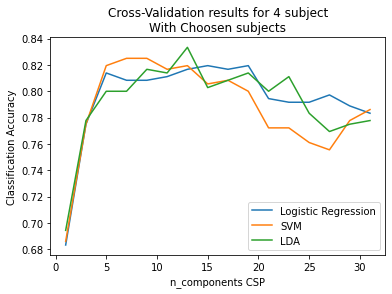

In [66]:
def train_model(csp_components, X, y):
    csp = mne.decoding.CSP(n_components=csp_components, norm_trace=True)
    
    log_regressor = LogisticRegression(max_iter=10000)
    svc = SVC(C=1,kernel='linear')
    lda = LinearDiscriminantAnalysis()
    
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    scores_lr = []
    scores_svm = []
    scores_lda = []

    for train_idx, test_idx in cv.split(y):
        y_train, y_test = y[train_idx], y[test_idx]

        X_train = csp.fit_transform(X[train_idx], y_train)
        X_test = csp.transform(X[test_idx])

        # fit classifiers
        log_regressor.fit(X_train, y_train)
        svc.fit(X_train, y_train)
        lda.fit(X_train, y_train)
        
        scores_lr.append(log_regressor.score(X_test, y_test))
        scores_svm.append(svc.score(X_test, y_test))
        scores_lda.append(lda.score(X_test, y_test))
        
    return np.mean(scores_lr), np.mean(scores_svm), np.mean(scores_lda) #Returns mean accuracy for this hyperparameter value

n_components = np.arange(1,33,2)
print(n_components)
accuracy_lr = []
accuracy_svm = []
accuracy_lda = []

for number in n_components:
    lr_score, svm_score, lda_score = train_model(int(number), X, y)
    accuracy_lr.append( lr_score )
    accuracy_svm.append( svm_score )
    accuracy_lda.append( lda_score )

plt.plot(n_components, accuracy_lr, label="Logistic Regression")
plt.plot(n_components, accuracy_svm, label="SVM")
plt.plot(n_components, accuracy_lda, label="LDA")
plt.xlabel("n_components CSP")
plt.ylabel("Classification Accuracy")
plt.title("Cross-Validation results for 4 subject\nWith Choosen subjects")
plt.legend()
#plt.savefig("./results/Comparison of ML Models for EEG Classification-dpi-100 - Four Subjects - With Channel Selection.png", 
#             bbox_inches='tight', transparent=True, dpi=100)

Compare the results of dataset composed of our chosen subjects (using classification accuracy for each subject) with that of earlier results using dataset composed of Subjects 1,3,6,7.

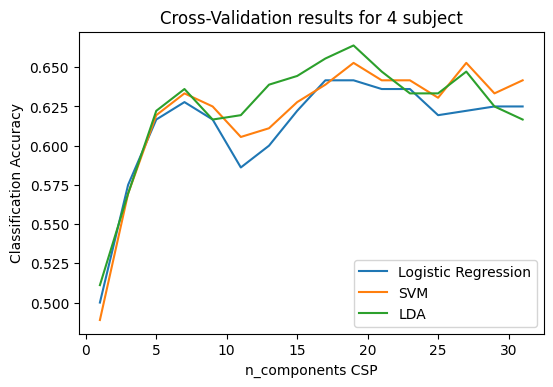

### Conclusions

We try to apply our classification models to first ten subjects in the dataset. We see that individual accuracy for each subject differs from the others. It seems that the EEG data for the subjects is not similar across all subjects. It is possible that the data is linearly separable for the case of some subjects but not for the others. 

Presence of artifacts may be another reason for the difference in classification accuracy. It is also possible that the preprocessing steps we have adapted, i.e. bandpass filtering, time cropping, etc is not suitable for data from some of the subjects.

### Further Tasks

Given X and y, perform Binary Classification to correctly identify an event as T1 or T2. 

<p>T1 = Clenching Fists  (Real or imagining)</p>
T2 = Moving Feet      (Real or imagining)

**Possible methods which may be used:**
1. <s>Logistic Regression (Linearly separable data only)</s>
2. <s>State Vector Machines</s>
3. <s>Linear Discriminant Analysis</s>
4. CNN + LSTM

**We may also try Feature Engineering and Selection to improve accuracy of our model.**
1. Artifact Handling using ICA (may be better to let the deep learning model handle it)
2. <s>Common Spatial Patterns Algorithm to extract features</s>
3. <s>Using a subset of functionally-relevant Electrodes (channels)</s>
4. Applying Baseline to the training data to get less noisy signal
5. Short-time Fast Fourier Transform
6. Wavelet Transform